In [1]:
from lightgbm import Dataset
from lightgbm import LGBMClassifier
from lightgbm import train
from matplotlib.pyplot import plot
from numpy import nan
from numpy import ndarray
from numpy import unique
from pandas import DataFrame
from pandas import read_csv
from pandas import Series
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [2]:
train_fname = '../input/spaceship-titanic/train.csv'
train_df = read_csv(filepath_or_buffer=train_fname)

In [3]:
def prepare(input_df: DataFrame) -> ndarray:
    result_df = input_df.drop(columns=['PassengerId', 'Name', 'Transported'], errors='ignore').copy(deep=True)
    result_df['Cabin_Deck'] = result_df['Cabin'].apply(func=lambda x: 'Unknown' if isinstance(x, float) else x.split('/')[0])
    result_df['Cabin_Side'] = result_df['Cabin'].apply(func=lambda x: 'Unknown' if isinstance(x, float) else x.split('/')[2])
    columns = ['CryoSleep', 'Destination', 'HomePlanet', 'VIP', 'Cabin_Deck', 'Cabin_Side']
    for column in columns:
        result_df[column] = LabelEncoder().fit_transform(y=result_df[column])
    result_df = result_df.drop(columns=['Cabin'])
    return result_df

# get the labels
y = train_df['Transported'].values
x_df = prepare(input_df=train_df)
# strategy = 'mean' # 'median' and 'most_frequent' are also possibilities
# imputer = SimpleImputer(missing_values=nan, strategy=strategy, fill_value=None, copy=True, add_indicator=False,)
imputer = KNNImputer(missing_values=nan, n_neighbors=2, weights='uniform', metric='nan_euclidean', copy=True, add_indicator=False,)
x = imputer.fit_transform(x_df)

In [4]:
# split
random_state = 1
x, x_test, y, y_test = train_test_split(x, y, test_size=0.2, random_state=random_state, stratify=y)
train_data = Dataset(x, label=y) #, categorical_feature='auto')
test_data = Dataset(x_test, label=y_test)

In [5]:
model = LGBMClassifier(
    boosting_type=['gbdt', 'dart', 'goss',][0], 
    class_weight=None, 
    colsample_bytree=1.0, 
    early_stopping_round = 20,
    importance_type=['gain', 'split'][1],
    learning_rate = 0.01,
    max_depth=-1,  
    min_child_weight=0.001, 
    min_child_samples=20, 
    min_split_gain=0.0, 
    n_estimators=[50, 100, 150, 200][1], 
    n_jobs=None, 
    num_iterations=800,
    num_leaves=31,
    objective=None, 
    random_state=random_state, 
    reg_alpha=0.0, 
    reg_lambda=0.0, 
    subsample_for_bin=200000, 
    subsample=1.0, 
    subsample_freq=0, 
)

In [6]:
model.fit(X=x, y=y, eval_set=(x_test, y_test), feature_name='auto', categorical_feature='auto',)

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[1]	valid_0's binary_logloss: 0.688933
[2]	valid_0's binary_logloss: 0.684879
[3]	valid_0's binary_logloss: 0.680968
[4]	valid_0's binary_logloss: 0.677021
[5]	valid_0's binary_logloss: 0.673207
[6]	valid_0's binary_logloss: 0.66943
[7]	valid_0's binary_logloss: 0.665695
[8]	valid_0's binary_logloss: 0.662066
[9]	valid_0's binary_logloss: 0.658535
[10]	valid_0's binary_logloss: 0.654992
[11]	valid_0's binary_logloss: 0.651531
[12]	valid_0's binary_logloss: 0.648122
[13]	valid_0's binary_logloss: 0.644753
[14]	valid_0's binary_logloss: 0.641455
[15]	valid_0's binary_logloss: 0.638233
[16]	valid_0's binary_logloss: 0.63506
[17]	valid_0's binary_logloss: 0.631952
[18]	valid_0's binary_logloss: 0.628896
[19]	valid_0's binary_logloss: 0.625901
[20]	valid_0's binary_logloss: 0.622931
[21]	valid_0's binary_logloss: 0.620077
[22]	valid_0's binary_logloss: 0.617319
[23]	valid_0's binary_logloss: 0.614539
[24]	valid_0's binary_logloss: 0.6118
[25]	valid_0's binary_logloss: 0.609111
[26]	valid_0'

LGBMClassifier(early_stopping_round=20, learning_rate=0.01, n_jobs=None,
               num_iterations=800, random_state=1)

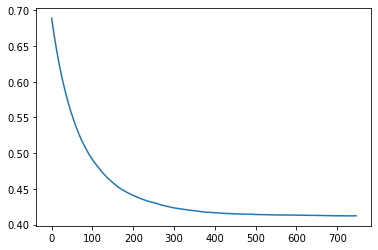

In [7]:
plot(model.evals_result_['valid_0']['binary_logloss'])

<AxesSubplot:>

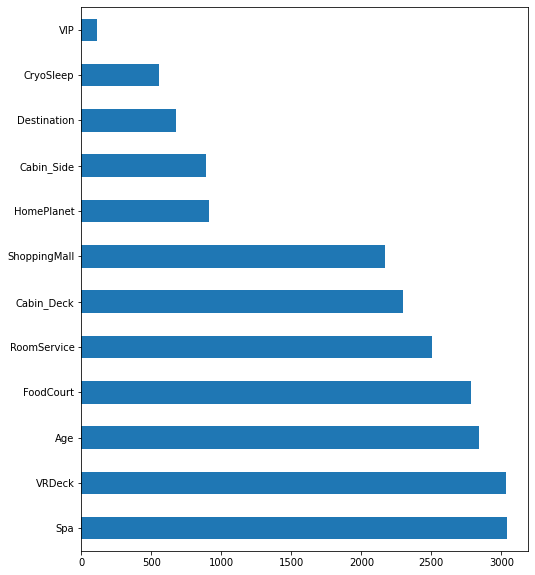

In [8]:
importance = Series(model.feature_importances_, index=x_df.columns)
importance.nlargest(30).plot(kind='barh', figsize=(8,10))

In [9]:
submission_df = read_csv('../input/spaceship-titanic/test.csv')
ids = submission_df['PassengerId'].values
submission_data_df = prepare(input_df=submission_df)
submission_data = imputer.transform(submission_data_df)
output_df = DataFrame({'PassengerId': ids, 'Transported': model.predict(submission_data) == 1.0})
output_df.to_csv('submission.csv', index=False)

{False: 1966, True: 2311}

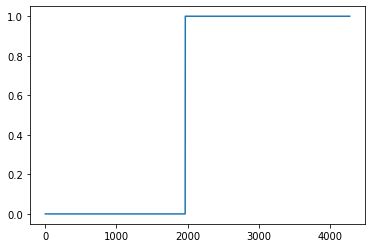

In [10]:
y_pred = model.predict(submission_data)
plot(sorted(y_pred.tolist()), )
values, counts = unique(y_pred, return_counts=True)
dict(zip(values, counts))